## Install dependencies and imports

In [ ]:
!pip install -U tensorflow-gpu==1.15 --force-reinstall

In [ ]:
# !pip install -U tensorflow_addons==0.6.0

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 16.7MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489402 sha256=4c8dc0d542fc2a6b51cb4eac3743b142269c98b55851a3e030202a87acd4270d
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [ ]:
!git clone https://github.com/punyajoy/HateXplain.git

Cloning into 'HateXplain'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 373 (delta 64), reused 50 (delta 21), pack-reused 250
Receiving objects: 100% (373/373), 4.81 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [ ]:
! pip install chart_studio

     |████████████████████████████████| 71kB 7.6MB/s 


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-02-13 20:10:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-13 20:10:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-13 20:10:57--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
import json
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean, cosine

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score, v_measure_score, completeness_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
# import chart_studio.plotly as py
import seaborn as sns
import shap

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score
import chart_studio
import chart_studio.plotly as py
chart_studio.tools.set_credentials_file(username='sahismiley11', api_key='J1yRVZGaubVHnaobBiex')
pd.set_option('display.max_colwidth', 1000)

In [ ]:
tf.__version__

'1.15.0'

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15524666180558414410
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3586853601056195814
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8545516066279325801
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14949928141
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15163938415994464240
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
def get_annotated_data(params):
    #temp_read = pd.read_pickle(params['data_file'])
    with open(params['data_file'], 'r') as fp:
        data = json.load(fp)
    dict_data=[]
    for key in data:
        temp={}
        temp['post_id']=key
        temp['text']=data[key]['post_tokens']
        final_label=[]
        for i in range(1,4):
            temp['annotatorid'+str(i)]=data[key]['annotators'][i-1]['annotator_id']
#             temp['explain'+str(i)]=data[key]['annotators'][i-1]['rationales']
            temp['target'+str(i)]=data[key]['annotators'][i-1]['target']
            temp['label'+str(i)]=data[key]['annotators'][i-1]['label']
            final_label.append(temp['label'+str(i)])

        final_label_id=max(final_label,key=final_label.count)
        temp['rationales']=data[key]['rationales']
            
        if(params['class_names']=='Data/classes_two.npy'):
            if(final_label.count(final_label_id)==1):
                temp['final_label']='undecided'
            else:
                if(final_label_id in ['hatespeech','offensive']):
                    final_label_id='toxic'
                else:
                    final_label_id='non-toxic'
                temp['final_label']=final_label_id

        
        else:
            if(final_label.count(final_label_id)==1):
                temp['final_label']='undecided'
            else:
                temp['final_label']=final_label_id

        
        
        
        dict_data.append(temp)    
    temp_read = pd.DataFrame(dict_data)  
    return temp_read    

## Download dataset

In [ ]:
dict_data_folder={
      '2':{'data_file':'HateXplain/Data/dataset.json','class_label':'Data/classes_two.npy'},
      '3':{'data_file':'HateXplain/Data/dataset.json','class_label':'Data/classes.npy'}
}

params = {}

# We need to load the dataset with the labels as 'toxic' and 'non-toxic'. 
# We consider hatespeech and offensive as toxic and normal as non-toxic.
params['num_classes']=2  
params['data_file']=dict_data_folder[str(params['num_classes'])]['data_file']
params['class_names']=dict_data_folder[str(params['num_classes'])]['class_label']

data_all_labelled=get_annotated_data(params)
data_all_labelled.head()
data_all_labelled['processed'] = data_all_labelled['text'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
df = pd.DataFrame()
df['text'] = data_all_labelled['processed']
df['label'] = data_all_labelled['final_label']
df['label'].replace('toxic', 1, inplace=True)
df['label'].replace('non-toxic', 0, inplace=True)

df = df[df['label']!='undecided']
df['label'].value_counts()

1    11415
0     7814
Name: label, dtype: int64

## Splitting and tokenizing data

In [ ]:
x = df['text'].values
y = df['label'].values

In [ ]:
np.random.seed(50)
indices =  np.random.randint(low=0, high=x.shape[0], size=x.shape[0])
train_indices = indices[0:round(0.8*x.shape[0])]
test_indices = indices[round(0.8*x.shape[0]): round(0.9*x.shape[0])]
pool_indices = indices[round(0.9*x.shape[0]):]
df_train = df.iloc[train_indices]['text'].values
df_test = df.iloc[test_indices]['text'].values
df_pool = df.iloc[pool_indices]['text'].values
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]
x_pool = x[pool_indices]
y_pool = y[pool_indices]

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train)

X_train = tokenizer.texts_to_sequences(df_train)
X_test = tokenizer.texts_to_sequences(df_test)
X_pool = tokenizer.texts_to_sequences(df_pool)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(df_train[2])
print(X_train[2])

many of us have tried to explain that right wing does not always equate to white supremacy they stuck their fingers in their ears and said la la la la fuck it we are all white supremacists now unitetheright charlottesville
[155, 7, 95, 20, 769, 3, 1221, 13, 101, 843, 115, 10, 169, 3, 15, 934, 16, 1395, 44, 2824, 12, 44, 3286, 4, 147, 994, 994, 994, 994, 75, 14, 40, 11, 23, 15, 757, 84, 4999, 2115]


In [ ]:
path_to_glove_file = "glove.6B.300d.txt"


embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print(reverse_word_map)

{1: 'the', 2: 'a', 3: 'to', 4: 'and', 5: 'i', 6: 'user', 7: 'of', 8: 'you', 9: 'is', 10: 'not', 11: 'are', 12: 'in', 13: 'that', 14: 'it', 15: 'white', 16: 'they', 17: 'for', 18: 'number', 19: 'be', 20: 'have', 21: 'do', 22: 'this', 23: 'all', 24: 'on', 25: 'with', 26: 'nigger', 27: 'like', 28: 'my', 29: 'but', 30: 'so', 31: 'was', 32: 'your', 33: 'as', 34: 'people', 35: 'just', 36: 'will', 37: 'he', 38: 'if', 39: 'who', 40: 'we', 41: 'can', 42: 'or', 43: 'by', 44: 'their', 45: 'no', 46: 'what', 47: 'women', 48: 'from', 49: 'about', 50: 'me', 51: 'them', 52: 'am', 53: 'up', 54: 'at', 55: 'out', 56: 'jews', 57: 'get', 58: 'how', 59: 'there', 60: 'bitch', 61: 'fucking', 62: 'when', 63: 'muslim', 64: 'an', 65: 'she', 66: 'kike', 67: 'one', 68: 'would', 69: 'retarded', 70: 'ghetto', 71: 'shit', 72: 'his', 73: 'more', 74: 'hate', 75: 'fuck', 76: 'because', 77: 'has', 78: 'black', 79: 'why', 80: 'some', 81: 'being', 82: 'only', 83: 'know', 84: 'now', 85: 'niggers', 86: 'raped', 87: 'gay', 88

In [ ]:

num_tokens = vocab_size + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 16917 words (3387 misses)


In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Fit model

In [ ]:
max_features = vocab_size
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 16
n_epochs = 20
model_select = 'rnn'

print('Loading data...')
(x_train, y_train), (x_test, y_test) = (X_train, y_train), (X_test, y_test)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
x_train = np.asarray(x_train).astype(np.float32)
y_train =np.asarray(y_train).astype(np.float32)
x_test =np.asarray(x_test).astype(np.float32)
y_test =np.asarray(y_test).astype(np.float32)
print('Build model...'+ model_select)
if model_select == 'birnn':
  model = Sequential()
  model.add(Embedding(vocab_size, 128))
  model.add(SpatialDropout1D(0.4))
  model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
  # model.add(Bidirectional(LSTM(10)))
  # model.add(Flatten())
  model.add(Dense(1, activation="sigmoid"))
  
else:
  model = Sequential()
  model.add(embedding_layer)
  # model.add(SpatialDropout1D(0.4))
  model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation="sigmoid"))

opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-5)
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print('Train...')
history  = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=n_epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Validation score:', score)
print('Validation accuracy:', acc)

Loading data...
15383 train sequences
1923 test sequences
Pad sequences (samples x time)
x_train shape: (15383, 80)
x_test shape: (1923, 80)
Build model...rnn
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train...
Train on 15383 samples, validate on 1923 samples
Epoch 1/20
15383/15383 [==============================] - 102s 7ms/sample - loss: 0.5569 - acc: 0.6995 - val_loss: 0.4914 - val_acc: 0.7546
Epoch 2/20
15383/15383 [==============================] - 101s 7ms/sample - loss: 0.4735 - acc: 0.7671 - val_loss: 0.4513 - val_acc: 0.7806
Epoch 3/20
15383/15383 [==============================] - 101s 7ms/sample - loss: 0.4133 - acc: 0.8079 - val_loss: 0.4317 - val_acc: 0.8086
Epoch 4/20
15383/15383 [==============================] - 101s 7ms/sample - loss: 0.3474 - acc: 0.8485 - val_loss: 0.3906 - val_acc: 0.8253
Epoch 5/20
15383/15383 [========================

In [ ]:
x_train.shape

(15383, 80)

# Test Model and explain predictions

In [ ]:
# Plot epochs vs train and test scores
# data = [go.Scatter(x=list(range(n_epochs)), y=homogeneity_scores, mode="lines", name="homogeneity"),


1923/1923 [==============================] - 2s 849us/sample
Overall F1 Score 0.898224339540927


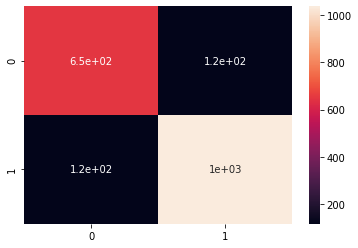

In [ ]:
predictions = model.predict_classes(x_test, verbose=1)
print('Overall F1 Score', f1_score(predictions, y_test))
sns.heatmap(confusion_matrix(y_test, predictions),annot=True)

In [ ]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:5000])



In [ ]:
x_test.shape

(1923, 80)

In [ ]:
# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
import random
shap_values = explainer.shap_values(x_test[:500])

ResourceExhaustedError: ignored

In [ ]:
shap_values[0][0].shape

In [ ]:
# Creating a reverse dictionary

shap.summary_plot(shap_values[0], x_test[:500], reverse_word_map)

In [ ]:
# transform the indexes to words
import numpy as np
# use number to words map to get x_test in form of words
num2word = reverse_word_map
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])



In [ ]:
postive_indices = np.where(y_test[:1000] == 1)
index = postive_indices[0][4]
shap.force_plot(explainer.expected_value[0], shap_values[0][index], x_test_words[index], matplotlib=True), df_test[index]

In [ ]:
shap_values[0].shape

In [ ]:
shap_values_pool = shap_values[0]
n_clusters = 50
kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1, max_iter=600)
kmeans.fit(shap_values_pool)

In [ ]:
homogeneity_score( y_test[:500], kmeans.labels_), v_measure_score(y_test[:500], kmeans.labels_)

In [ ]:
# Find similarity of each point in cluster to its centroid
similarity_to_center = []
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i] # cluster of this instance
    centroid = kmeans.cluster_centers_[cluster_label] # cluster center of the cluster of that instance
    similarity = 1-cosine(instance, centroid) # 1- cosine distance gives similarity
    similarity_to_center.append(similarity)
    
centroid_match = [None]*n_clusters
centroid_indices =[None]*n_clusters
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i]     
    if centroid_match[cluster_label] is None or similarity_to_center[i] > centroid_match[cluster_label]:
        centroid_indices[cluster_label] = i
        centroid_match[cluster_label] = similarity_to_center[i]

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=20)
principals = tsne.fit_transform(shap_values_pool)

In [ ]:
df_pool = df_test
classwise_uncertainty = model.predict_proba(x_test)
uncertainty = 1 - np.max(classwise_uncertainty, axis=1)

In [ ]:
data = []
colorscale = [[0, 'mediumturquoise'], [1, 'salmon']]
collect = dict()
sizes = []
color = ['hsl(' + str(h) + ',80%' + ',50%)' for h in np.linspace(0, 255, n_clusters)]
df_final_labels = pd.DataFrame()
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    
    cluster_text = df_pool[cluster_indices]
    center_index = centroid_indices[cluster_id]
    center_text = df_pool[center_index]
    sizes.append(len(cluster_indices[0]))
    df_cluster = pd.DataFrame({'text': cluster_text})
    df_cluster['cluster_id'] = cluster_id
    df_cluster['centroid'] = False
    df_cluster = df_cluster.append({'text':center_text, 'cluster_id':cluster_id,
                                    'centroid':True }, ignore_index=True)
    df_final_labels = pd.concat([df_final_labels, df_cluster])

    cp = principals[cluster_indices]
    # data.append(go.Heatmap(x=cp[:, 0],
    #                        y=cp[:, 1],
    #                        z=uncertainty[cluster_indices],
    #                        name='uncertainity map',
    #                        visible=True,
    #                        showscale=False,
    #                        colorscale=colorscale,
    #                                      ))
    data.append(go.Scatter(x = cp[:,0],
                   y = cp[:,1],
                   mode='markers',                    
                hovertext=cluster_text,
                            marker=dict(color=color[cluster_id],
                                                   size=10),
                           name = 'cluster '+ str(cluster_id)
                          ))
    # data.append(go.Scatter(x = [principals[center_index, 0]],
    #                y = [principals[center_index, 1]],
    #                mode='markers',  
    #                        marker=dict(color=color[cluster_id],
    #                                                size=15,
    #                                                line=dict(color='black', width=5)),
    #                        name = 'centroid cluster '+ str(cluster_id),
    #                        visible='legendonly',
                           
    #                       ))
    collect[cluster_id] = df_pool[cluster_indices]
    
fig = go.Figure(data=data)
fig.show()
df_final_labels.to_csv('df_input.csv')

## Analyze uncertainty within clusters

In [ ]:
data = []
ranges = []
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    uncertainty_cluster = uncertainty[cluster_indices]
    rng = np.max(uncertainty_cluster)- np.min(uncertainty_cluster)
    ranges.append(rng)


    data.append(go.Histogram(x=uncertainty_cluster, name=str(cluster_id), showlegend=True,visible='legendonly'))
fig = go.Figure(data=data)
url=py.plot(fig, filename='clusters_50', sharing='public')

In [ ]:
ranges

In [ ]:
plt.hist(ranges)

In [ ]:
max_uncertain_indices = (-uncertainty).argsort()[:20]
y_test[max_uncertain_indices], uncertainty[max_uncertain_indices]

In [ ]:
max_uncertain_indices

In [ ]:
cluster_id = 2
cluster_indices = np.where(kmeans.labels_ == cluster_id)    
d = {'text' : df_pool[cluster_indices], 'uncertainty': uncertainty[cluster_indices], 'label': y_test[cluster_indices]}

pd.DataFrame(d)

In [ ]:
def get_keywords(shap_values_pool):
    print("shap values", len(shap_values_pool))
    feature_names = reverse_word_map
    arr = shap_values_pool
    arr[arr == 0] = np.nan
    arr_pos = shap_values_pool
    arr_neg = shap_values_pool
    # arr_pos[arr_pos <= 0] = np.nan
    # arr_neg[arr_neg >= 0] = np.nan
    indices = np.nanargmax(arr, axis=1)
    pos_indices = np.nanargmax(arr_pos, axis=1)
    neg_indices = np.nanargmin(arr_neg, axis=1)
    key_words = np.array([feature_names[indices]]).T
    key_words_pos = np.array([feature_names[pos_indices]]).T
    key_words_neg = np.array([feature_names[neg_indices]]).T

In [ ]:
get_keywords(shap_values_pool)